In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [0]:
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes =  np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

In [3]:
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

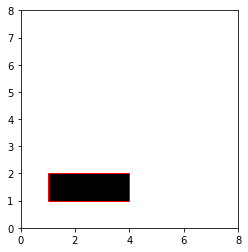

In [4]:
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])

for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [5]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), 7.182698880114913e-17, 0.9999999999999996)

In [6]:
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 4), 0.2815525, 0.17535473616001934)

In [0]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = Sequential([
        Dense(200, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.2), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [9]:
model.fit(train_X, train_y, nb_epoch=30, validation_data=(test_X, test_y), verbose=2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.



Train on 40000 samples, validate on 10000 samples
Epoch 1/30





 - 13s - loss: 0.0252 - val_loss: 7.2105e-04
Epoch 2/30
 - 4s - loss: 0.0018 - val_loss: 2.9160e-04
Epoch 3/30
 - 4s - loss: 0.0013 - val_loss: 2.1343e-04
Epoch 4/30
 - 4s - loss: 0.0011 - val_loss: 1.4291e-04
Epoch 5/30
 - 4s - loss: 0.0010 - val_loss: 1.4195e-04
Epoch 6/30
 - 4s - loss: 9.4597e-04 - val_loss: 1.2132e-04
Epoch 7/30
 - 3s - loss: 9.0330e-04 - val_loss: 1.2536e-04
Epoch 8/30
 - 4s - loss: 8.7191e-04 - val_loss: 1.1418e-04
Epoch 9/30
 - 4s - loss: 8.4794e-04 - val_loss: 1.0392e-04
Epoch 10/30
 - 4s - loss: 8.0465e-04 - val_loss: 7.5146e-05
Epoch 11/30
 - 4s - loss: 7.9633e-04 - val_loss: 1.0301e-04
Epoch 12/30
 - 4s - loss: 7.7319e-04 - val_loss: 1.1988e-04
Epoch 13/30
 - 4s - loss: 7.6422e-04 - val_loss: 7.6932e-05
Epoch 14/30
 - 4s - loss: 7.4782e-04 - val_loss: 6.6750e-05
Epoch 15/30
 - 4s - loss: 7.3905e-04 - val_loss: 7.1636e-05
Epoch 16/30
 - 3s - loss: 7.2280e-04 - val_loss: 5.6941e-05
Epoch 17/30


In [11]:
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [0]:

def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

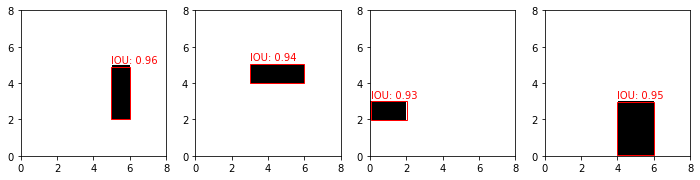

In [13]:
plt.figure(figsize=(12, 3))

for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        

In [14]:
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.8804762557078366

In [0]:
#detecting two objects/rectangkes